In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_paths = ['/content/img11.jpg', '/content/img12.jpg', '/content/img13.jpg']
test_paths = ['/content/img4.jpg', '/content/img6.jpg']


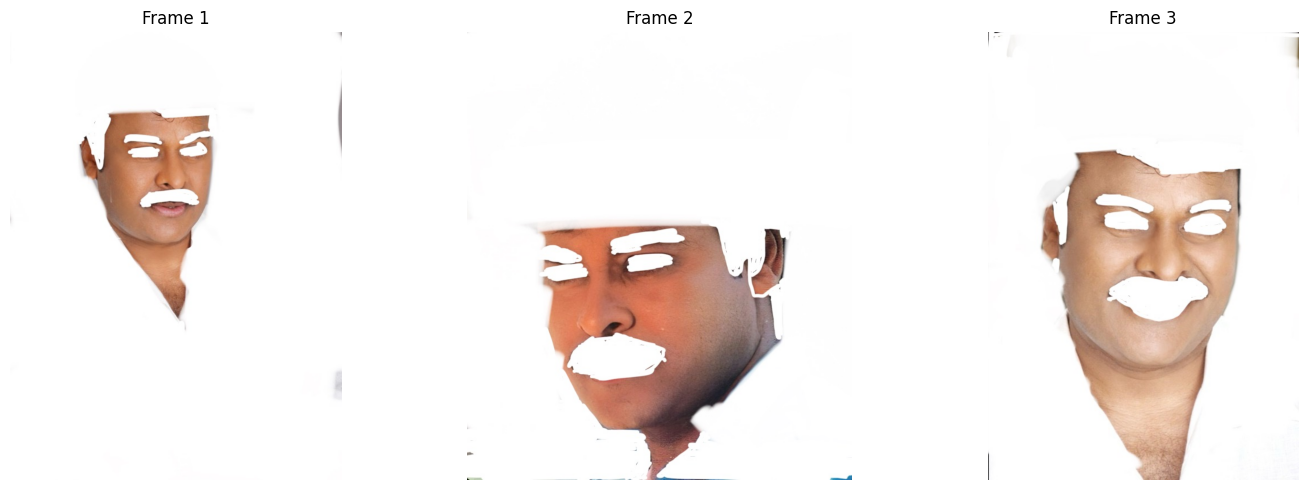

In [3]:

frames = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in train_paths]

plt.figure(figsize=(15, 5))
for idx, img in enumerate(frames):
    plt.subplot(1, len(frames), idx + 1)
    plt.imshow(img)
    plt.title(f'Frame {idx + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
skin_pixels = []
for path in train_paths:
    img = cv2.imread(path)
    for row in img:
        for pixel in row:
            if not (pixel == [255, 255, 255]).all():
                skin_pixels.append(pixel)
skin_pixels = np.array(skin_pixels, dtype=np.float32)


In [5]:
mean = np.mean(skin_pixels, axis=0)
cov = np.cov(skin_pixels, rowvar=False)
inv_cov = np.linalg.inv(cov)


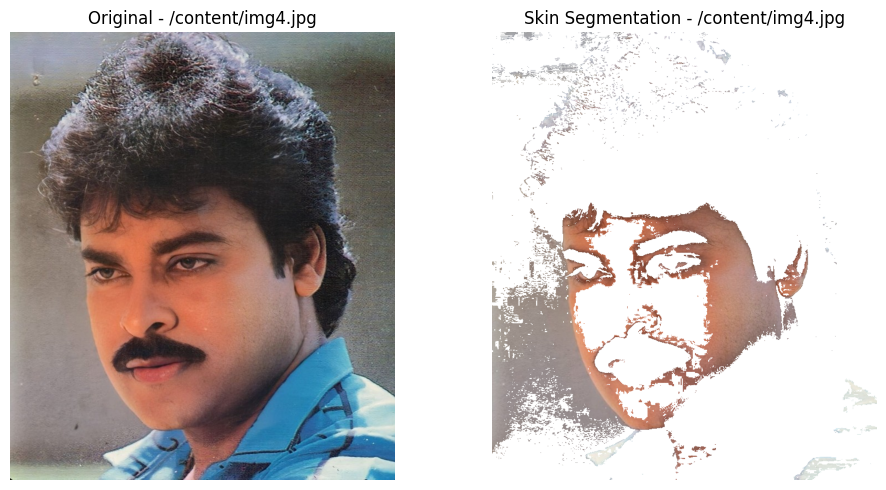

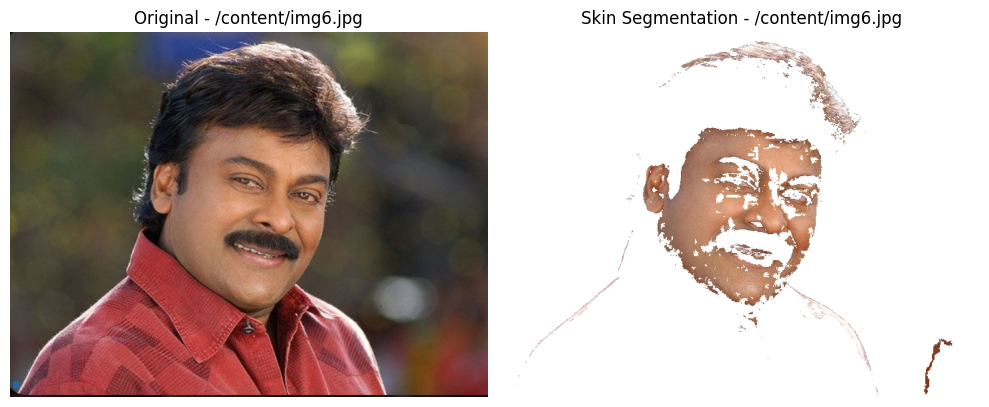

In [6]:

for path in test_paths:
    original = cv2.imread(path)
    if original is None:
        print(f"Error loading image: {path}")
        continue

    result = np.ones_like(original) * 255
    rows, cols, _ = original.shape
    for i in range(rows):
        for j in range(cols):
            pixel = original[i, j].astype(np.float32)
            diff = pixel - mean
            dist = np.dot(np.dot(diff, inv_cov), diff.T)
            if dist < 6.0:
                result[i, j] = original[i, j]

    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title(f'Original - {path}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_rgb)
    plt.title(f'Skin Segmentation - {path}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    cv2.imwrite(f'skin_{path}', result)


HISTOGRAM ANALYSIS

Visualizing skin vs. non-skin histograms...


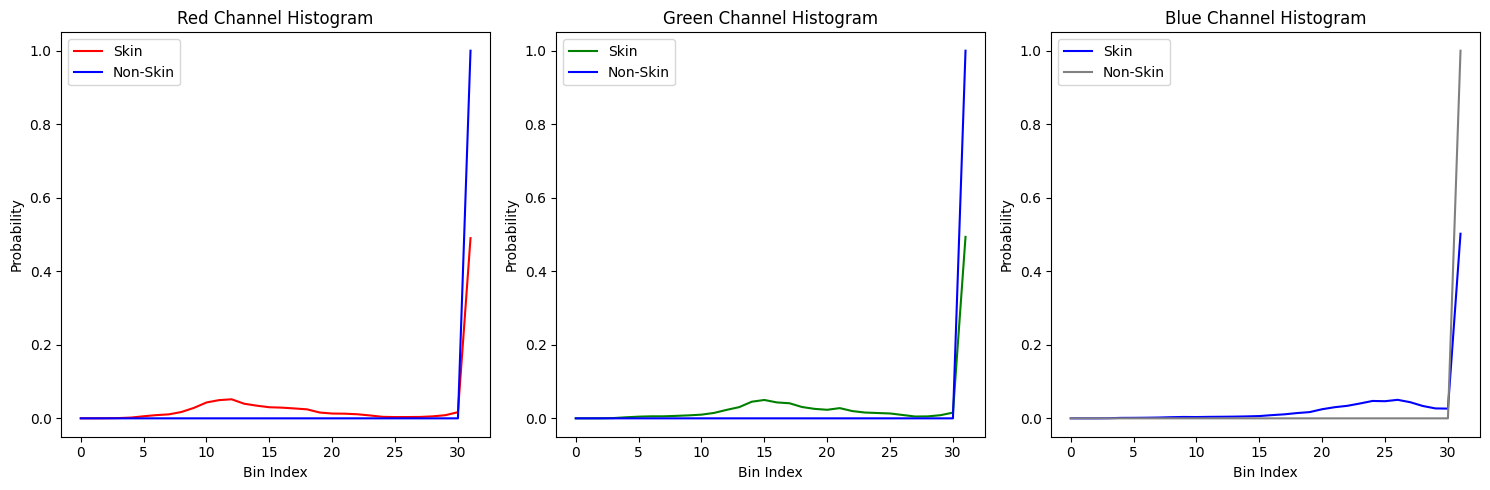

Histograms displayed above (showing separability of skin vs. non-skin distributions).



In [8]:
print("Visualizing skin vs. non-skin histograms...")

skin_pixels = []
nonskin_pixels = []

for path in train_paths:
    img = cv2.imread(path)
    for row in img:
        for pixel in row:
            if not (pixel == [255, 255, 255]).all():  # Not white (skin)
                skin_pixels.append(pixel)
            else:
                nonskin_pixels.append(pixel)

skin_pixels = np.array(skin_pixels, dtype=np.float32)
nonskin_pixels = np.array(nonskin_pixels, dtype=np.float32)

bin_size = 256 // 32
skin_histogram = np.zeros((32, 32, 32), dtype=np.float64)
nonskin_histogram = np.zeros((32, 32, 32), dtype=np.float64)

total_skin = 0
total_nonskin = 0

for pixel in skin_pixels:
    r, g, b = pixel
    r_bin = min(int(r) // bin_size, 31)
    g_bin = min(int(g) // bin_size, 31)
    b_bin = min(int(b) // bin_size, 31)
    skin_histogram[r_bin, g_bin, b_bin] += 1
    total_skin += 1

for pixel in nonskin_pixels:
    r, g, b = pixel
    r_bin = min(int(r) // bin_size, 31)
    g_bin = min(int(g) // bin_size, 31)
    b_bin = min(int(b) // bin_size, 31)
    nonskin_histogram[r_bin, g_bin, b_bin] += 1
    total_nonskin += 1

if total_skin > 0:
    skin_histogram /= total_skin
if total_nonskin > 0:
    nonskin_histogram /= total_nonskin

skin_histogram = np.maximum(skin_histogram, 1e-10)
nonskin_histogram = np.maximum(nonskin_histogram, 1e-10)

skin_r = np.sum(skin_histogram, axis=(1, 2))
nonskin_r = np.sum(nonskin_histogram, axis=(1, 2))
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(skin_r, label='Skin', color='red')
plt.plot(nonskin_r, label='Non-Skin', color='blue')
plt.title('Red Channel Histogram')
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.legend()

skin_g = np.sum(skin_histogram, axis=(0, 2))
nonskin_g = np.sum(nonskin_histogram, axis=(0, 2))
plt.subplot(1, 3, 2)
plt.plot(skin_g, label='Skin', color='green')
plt.plot(nonskin_g, label='Non-Skin', color='blue')
plt.title('Green Channel Histogram')
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.legend()

skin_b = np.sum(skin_histogram, axis=(0, 1))
nonskin_b = np.sum(nonskin_histogram, axis=(0, 1))
plt.subplot(1, 3, 3)
plt.plot(skin_b, label='Skin', color='blue')
plt.plot(nonskin_b, label='Non-Skin', color='gray')
plt.title('Blue Channel Histogram')
plt.xlabel('Bin Index')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

print("Histograms displayed above (showing separability of skin vs. non-skin distributions).\n")
